In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-10-02 15:55:58 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-10-02 15:55:59 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-10-02 15:55:59 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
# model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-10-02 15:56:08 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-02 15:56:08 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-02 15:56:09 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-10-02 15:56:09 wandb.docker.auth DEBUG    No config file found


## Parsing the sweep results

2025-10-02 15:56:16 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-10-02 15:56:16 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-10-02 15:56:16 matplotlib DEBUG    interactive is False
2025-10-02 15:56:16 matplotlib DEBUG    platform is linux
2025-10-02 15:56:16 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-10-02 15:56:16 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-10-02 15:56:16 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-02 15:56:16 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-02 15:56:19 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-10-02 15:56:19 matplotlib.font

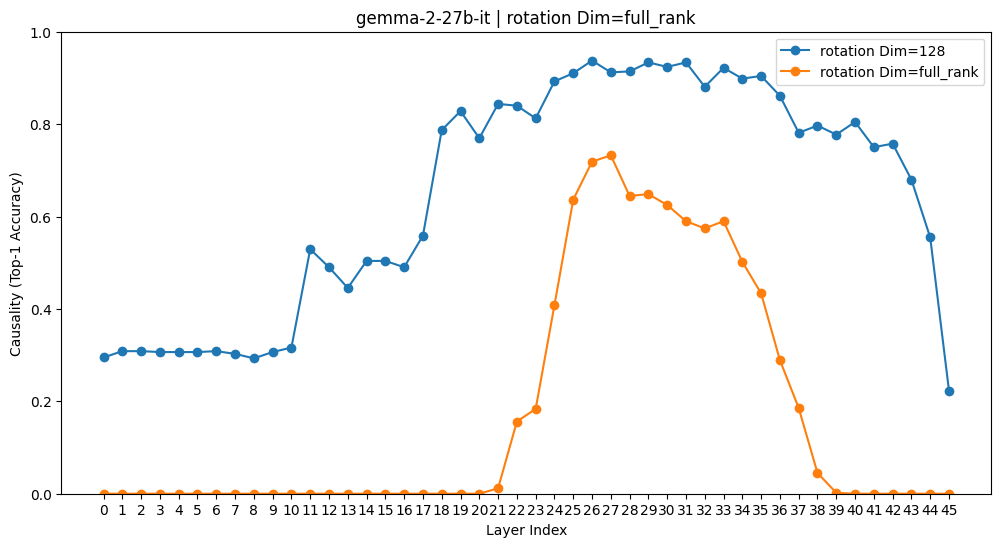

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))

###################################
projection_dims = [128, "full_rank"]
###################################

for projection_dim in projection_dims:
    sweep_root = os.path.join(
        env_utils.DEFAULT_RESULTS_DIR,
        "selection/das_projections/sweep",
        model_key.split("/")[-1],
        str(projection_dim)
    )

    layer_name_format = "model.layers.{}"
    n_layer = 46

    causality = []
    for layer_idx in range(n_layer):
        layer_name = layer_name_format.format(layer_idx)
        validation_file_path = os.path.join(sweep_root, layer_name, "validation_results.json")
        with open(validation_file_path, "r") as f:
            validation_results = json.load(f)
        top_1_accuracy = validation_results["summary"]["top_1_accuracy"]
        causality.append(top_1_accuracy)
        # print(f"{layer_name}: causality={top_1_accuracy:.3f}")
    plt.plot(range(n_layer), causality, marker='o')


plt.xticks(range(n_layer))
plt.xlabel("Layer Index")
plt.ylabel("Causality (Top-1 Accuracy)")
plt.title(f"{model_key.split('/')[-1]} | rotation Dim={projection_dim}")
plt.ylim(0, 1)
plt.legend([f"rotation Dim={dim}" for dim in projection_dims])
plt.show()

## Load LM and the Select Task

In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # torch_dtype=torch.float32,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-10-02 15:48:24 src.models WARNING  Qwen/Qwen2.5-32B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-10-02 15:48:24 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-10-02 15:48:24 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-32B-Instruct/resolve/main/config.json HTTP/1.1" 307 0
2025-10-02 15:48:24 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-32B-Instruct/5ede1c97bbab6ce5cda5812749b4c0bdf79b18dd/config.json HTTP/1.1" 200 0
2025-10-02 15:48:24 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-32B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 307 0
2025-10-02 15:48:24 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-32B-Instruct/5ede1c97bbab6ce5cda5812749b4c0bdf79b18dd/toke

Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

2025-10-02 15:48:44 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-32B-Instruct/resolve/main/generation_config.json HTTP/1.1" 307 0
2025-10-02 15:48:45 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2.5-32B-Instruct/5ede1c97bbab6ce5cda5812749b4c0bdf79b18dd/generation_config.json HTTP/1.1" 200 0
2025-10-02 15:48:45 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-32B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-10-02 15:48:45 src.models INFO     loaded model <Qwen/Qwen2.5-32B-Instruct> | size: 62492.135 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [6]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input
from src.selection.data import get_counterfactual_samples_within_task

In [7]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    mt=mt,
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    patch_n_distractors=5,
    clean_n_distractors=5
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

print(patch_sample.prompt(), ">>", patch_sample.obj)
print(clean_sample.prompt(), ">>", clean_sample.obj)

2025-10-02 15:48:47 src.selection.data INFO     clean_obj_idx=4 | ['Raspberry', 'Dresser', 'Temple', 'Suit', 'Helicopter', 'Camera']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-02 15:48:48 src.selection.data INFO     # Options: Museum, Accordion, Soap, Yacht, Shirt, Banana.
Which among these objects mentioned above is a fruit?
Answer:
2025-10-02 15:48:48 src.selection.data INFO     Raspberry | fruit -> Banana | pred=['" Banana"[75824] (p=0.941, logit=30.000)', '" The"[576] (p=0.028, logit=26.500)', '" Among"[21658] (p=0.020, logit=26.125)', '" \n"[715] (p=0.004, logit=24.500)', '" \n\n"[4710] (p=0.002, logit=23.875)']
2025-10-02 15:48:49 src.selection.data INFO     # Options: Raspberry, Dresser, Temple, Suit, Helicopter, Camera.
Which among these objects mentioned above is a vehicle?
Answer:
2025-10-02 15:48:49 src.selection.data INFO     Truck | vehicle -> Helicopter | pred=['" Hel"[15806] (p=0.574, logit=27.375)', '" None"[2240] (p=0.164, logit=26.125)', '" Among"[2

## Training Set

In [8]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

train_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "train",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
    # "profession",
    # "nationality",
    # "landmarks"
    # "rhymes"
)

os.makedirs(train_samples_save_path, exist_ok=True)


free_gpu_cache()
train_set = []
train_limit = 32
start_from = 1

counterfactual_sampler = get_counterfactual_samples_interface[select_task.task_name]

while len(train_set) < train_limit:
    print(f"sample {len(train_set)+1} / {train_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_distractors=random.choice(range(2, 6)),
    )
    train_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(
            train_samples_save_path,
            f"{len(train_set) + start_from - 1:05d}.json",
        ),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(train_set)

sample 1 / 32
2025-10-02 15:25:09 src.selection.data INFO     clean_obj_idx=2 | ['Ash', 'Xylophone', 'Eagle', 'Tie', 'Celery']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-02 15:25:09 src.selection.data INFO     # Options: Bat, Coat, Bracelet, Dolphin, Daisy.
Which among these objects mentioned above is a clothing?
Answer:
2025-10-02 15:25:09 src.selection.data INFO     Hat | clothing -> Coat | pred=['" Coat"[67767] (p=0.840, logit=28.875)', '" The"[576] (p=0.061, logit=26.250)', '" Among"[21658] (p=0.047, logit=26.000)', '" \n\n"[4710] (p=0.015, logit=24.875)', '" ""[330] (p=0.014, logit=24.750)']
2025-10-02 15:25:10 src.selection.data INFO     # Options: Ash, Xylophone, Eagle, Tie, Celery.
Which among these objects mentioned above is a animal?
Answer:
2025-10-02 15:25:10 src.selection.data INFO     Giraffe | animal -> Eagle | pred=['" Eagle"[35795] (p=0.625, logit=27.375)', '" Among"[21658] (p=0.158, logit=26.000)', '" The"[576] (p=0.140, logit=25.875)', '" \n\n"[471

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f3cf2f39b50>>
Traceback (most recent call last):
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


sample 3 / 32
2025-10-02 15:25:12 src.selection.data INFO     clean_obj_idx=2 | ['Train', 'Violin', 'Lotion', 'Dress', 'Spinach']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-02 15:25:12 src.selection.data INFO     # Options: Shirt, Ambulance, Shower, Brooch, Smartwatch.
Which among these objects mentioned above is a clothing?
Answer:
2025-10-02 15:25:12 src.selection.data INFO     Sweater | clothing -> Shirt | pred=['" Shirt"[54707] (p=0.750, logit=28.250)', '" The"[576] (p=0.168, logit=26.750)', '" Among"[21658] (p=0.048, logit=25.500)', '" \n\n"[4710] (p=0.008, logit=23.750)', '" \n"[715] (p=0.007, logit=23.500)']
2025-10-02 15:25:12 src.selection.data INFO     # Options: Train, Violin, Lotion, Dress, Spinach.
Which among these objects mentioned above is a bathroom item?
Answer:
2025-10-02 15:25:12 src.selection.data INFO     Comb | bathroom item -> Lotion | pred=['" L"[444] (p=0.922, logit=30.500)', '" Among"[21658] (p=0.046, logit=27.500)', '" The"[576] (p=0.017, 

32

In [8]:
from src.selection.data import CounterFactualSamplePair
import random

train_set = []
train_limit = 1024

train_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "train",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
    # "profession",
    # "nationality"
    # "landmarks",
    # "rhymes",
)

sample_files = [
    os.path.join(train_samples_load_path, f)
    for f in os.listdir(train_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:train_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    # patch_category = cf_pair.patch_sample.category
    # random_category = random.choice(list(set(select_task.categories) - {patch_category}))
    # random_obj = random.choice(select_task.category_wise_examples[random_category])
    # cf_pair.patch_sample.options[cf_pair.patch_sample.obj_idx] = random_obj

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    train_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(train_set)

2025-10-02 15:48:53 __main__ INFO     Found 32 sample files


32

In [9]:
destination, source = random.choice(train_set)
print("Destination:", destination.prompt(), ">>", destination.obj)
print("Source:", source.prompt(), ">>", source.obj)

Destination: # Options: Dog, Factory, Tape, Food processor, Surfboard.
Which among these objects mentioned above is a building?
Answer: >> Factory
Source: # Options: Coat, Razor, School, Sheep, Stapler.
Which among these objects mentioned above is a animal?
Answer: >> Sheep


## Validation Set

In [13]:
from src.selection.data import CounterFactualSamplePair
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_interface
import random

data_type = "objects"
# data_type = "profession"
# data_type = "nationality"
select_val_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        f"{data_type}.json"
    )
)

validation_samples_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_val_task.task_name,
    data_type,
)

os.makedirs(validation_samples_save_path, exist_ok=True)

    
free_gpu_cache()
validation_set = []
validation_limit = 16
start_from = 0

counterfactual_sampler = get_counterfactual_samples_interface[select_task.task_name]

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = counterfactual_sampler(
        mt=mt,
        task=select_val_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style=OPTION_STYLE,
        n_distractors=random.choice(range(2, 6)),
    )
    validation_set.append((clean, patch))
    cf_pair = CounterFactualSamplePair(
        patch_sample=patch,
        clean_sample=clean,
    )
    cf_pair.detensorize()
    with open(
        os.path.join(
            validation_samples_save_path,
            f"{len(validation_set) + start_from - 1:05d}.json",
        ),
        "w",
    ) as f:
        json.dump(cf_pair.to_dict(), f, indent=2)

len(validation_set)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
sample 1 / 16
2025-10-02 11:49:55 src.selection.data INFO     clean_obj_idx=2 | ['Earring', 'Zebra', 'Asparagus']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-02 11:49:55 src.selection.data INFO     # Options: Rabbit, Onion, Maple.
Which among these objects mentioned above is a animal?
Answer:
2025-10-02 11:49:55 src.selection.data INFO     Eagle | animal -> Rabbit | pred=['" Rabbit"[48331] (p=0.945, logit=30.250)', '" The"[576] (p=0.029, logit=26.750)', '" Among"[21658] (p=0.017, logit=26.250)', '" \n\n"[4710] (p=0.003, logit=24.500)', '" \n"[715] (p=0.002, logit=24.125)']
2025-10-02 11:49:55 src.selection.data INFO     # Options: Earring, Zebra, Asparagus.
Which among these objects mentioned above is a vegetable?
Answer:
202

16

In [10]:
from src.selection.data import CounterFactualSamplePair
import random

# data_type = "profession"
data_type = "objects"

validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_task.task_name,
    data_type,
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-10-02 15:48:59 __main__ INFO     Found 16 sample files


16

## DAS

In [11]:
from src.utils.typing import TokenizerOutput
from src.functional import (
    get_module_nnsight,
    patch_with_baukit,
    get_hs,
    interpret_logits,
)
from src.tokens import prepare_input
from itertools import product
from src.functional import PatchSpec
from src.selection.utils import get_first_token_id
import baukit
from src.functional import patch_linear_subspaces

# TESTING

## get a validation sample
source, destination = train_set[19]
print(source.prompt(), ">>", source.obj)
print(destination.prompt(), ">>", destination.obj)

source_tokenized = prepare_input(prompts=[source.prompt()], tokenizer=mt)
destination_tokenized = prepare_input(prompts=[destination.prompt()], tokenizer=mt)

print("destination run")
destination_output = patch_with_baukit(mt=mt, inputs=destination_tokenized, patches=[])
destination_logits = destination_output.logits[:, -1, :]
destination_pred, destination_track = interpret_logits(
    logits=destination_logits,
    tokenizer=mt.tokenizer,
    interested_tokens=[
        get_first_token_id(opt, mt.tokenizer) for opt in destination.options
    ],
)
print(f"{[str(pred) for pred in destination_pred]}")
print(f"{[str(pred) for tok_id, (rank, pred) in destination_track.items()]}")


print("source run")
source_output = patch_with_baukit(mt=mt, inputs=source_tokenized, patches=[])
source_logits = source_output.logits[:, -1, :]
source_pred, source_track = interpret_logits(
    logits=source_logits,
    tokenizer=mt.tokenizer,
    interested_tokens=[get_first_token_id(opt, mt.tokenizer) for opt in source.options],
)
print(f"{[str(pred) for pred in source_pred]}")
print(f"{[str(pred) for tok_id, (rank, pred) in source_track.items()]}")

print("-" * 80)

## get patch hidden states
################################
layers = [mt.layer_name_format.format(25)]
token_indices = [-3, -2, -1]
################################
patch_locations = list(product(layers, token_indices))
source_hidden_states = get_hs(
    mt=mt, input=source_tokenized, locations=patch_locations, return_dict=True
)

## check the effect of patching the full residual states
patches = []
for module_name, token_index in patch_locations:
    patch_spec = PatchSpec(
        location=(module_name, token_index),
        patch=source_hidden_states[(module_name, token_index)],
        strategy="replace",
    )
    patches.append(patch_spec)

residual_patched_output = patch_with_baukit(
    mt=mt, inputs=destination_tokenized, patches=patches
)

print("residual patched run")
residual_patched_logits = residual_patched_output.logits[:, -1, :]
residual_patched_pred, residual_patched_track = interpret_logits(
    logits=residual_patched_logits,
    tokenizer=mt.tokenizer,
    interested_tokens=[
        get_first_token_id(opt, mt.tokenizer) for opt in destination.options
    ],
)
print(f"{[str(pred) for pred in residual_patched_pred]}")
print(f"{[str(pred) for tok_id, (rank, pred) in residual_patched_track.items()]}")

print("\n\nTESTING DAS")
rotator = {}
for layer_name in set([loc[0] for loc in patch_locations]):
    module = baukit.get_module(mt._model, layer_name)
    module_device = next(module.parameters()).device
    linear = torch.nn.Linear(mt.n_embd, mt.n_embd, bias=False).to(device=module_device)

    # initialize as identify
    # torch.nn.init.eye_(linear.weight)
    # initialize as orthogonal
    torch.nn.init.orthogonal_(linear.weight)

    rotator[layer_name] = linear.to(device=module_device, dtype=mt.dtype)

das_patched_output = patch_linear_subspaces(
    mt=mt,
    base_input=destination_tokenized,
    rotator=rotator,
    patches=patches,
    rotate_dimensions=mt.n_embd,
    with_grad=False,
)
das_patched_logits = das_patched_output.logits[:, -1, :]
das_patched_pred, das_patched_track = interpret_logits(
    logits=das_patched_logits,
    tokenizer=mt.tokenizer,
    interested_tokens=[
        get_first_token_id(opt, mt.tokenizer) for opt in destination.options
    ],
)
print(f"{[str(pred) for pred in das_patched_pred]}")
print(f"{[str(pred) for tok_id, (rank, pred) in das_patched_track.items()]}")

# Options: Skirt, Cat, Xylophone, Basketball, Highlighter, Grape.
Which among these objects mentioned above is a music instrument?
Answer: >> Xylophone
# Options: Trumpet, Cherry, Jeans, Bench, Eagle, Blender.
Which among these objects mentioned above is a fruit?
Answer: >> Cherry
destination run
['" Cherry"[44705] (p=0.957, logit=29.875)', '" None"[2240] (p=0.033, logit=26.500)', '" Among"[21658] (p=0.004, logit=24.375)', '" \n"[715] (p=0.003, logit=24.000)', '" The"[576] (p=0.002, logit=23.625)']
['" Cherry"[44705] (p=0.957, logit=29.875)', '" Eagle"[35795] (p=0.000, logit=18.500)', '" Trump"[3339] (p=0.000, logit=16.875)', '" Blender"[87568] (p=0.000, logit=15.312)', '" Bench"[35258] (p=0.000, logit=14.500)', '" Jeans"[81407] (p=0.000, logit=9.625)']
source run
['" X"[1599] (p=0.723, logit=29.125)', '" The"[576] (p=0.143, logit=27.500)', '" Among"[21658] (p=0.086, logit=27.000)', '" \n"[715] (p=0.015, logit=25.250)', '" Based"[20205] (p=0.009, logit=24.750)']
['" X"[1599] (p=0.723, 

In [12]:
test_tokenized = prepare_input(
    prompts=[
        source.prompt(), 
        destination.prompt()
    ], tokenizer=mt
)

test_hs = get_hs(
    mt=mt,
    input=test_tokenized,
    locations=[(mt.layer_name_format.format(15), -1)],
    return_dict=False,
)
test_hs.shape

torch.Size([2, 5120])

In [13]:
test_tokenized.input_ids.shape

torch.Size([2, 33])

In [14]:
mt.name.lower()

'qwen/qwen2.5-32b-instruct'

In [15]:
layer_name = mt.layer_name_format.format(15)
with mt.trace(test_tokenized) as tracer:
    layer = get_module_nnsight(mt, layer_name)
    h = layer.output.save()

In [16]:
h.shape

torch.Size([2, 33, 5120])

In [17]:
from torch.optim import AdamW
from src.selection.data import get_options_for_answer
from src.functional import free_gpu_cache
from src.utils.typing import PathLike
from src.selection.optimization import get_optimal_rotation

mt._model.zero_grad()
free_gpu_cache()

########################################################
projection_dim = 128
save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "das_projections",
    data_type,
    mt.name.split("/")[-1],
    str(projection_dim)
)
layers=[mt.layer_name_format.format(25)]
token_mapping={-3: -3, -2: -2, -1: -1}
#######################################################

optimal_rotator, training_losses = get_optimal_rotation(
    mt=mt,
    train_set=train_set,
    layers=layers,
    token_mapping=token_mapping,
    rotation_n_dim=projection_dim,
    learning_rate=1e-3,
    ortho_reg=0.1,
    n_epochs=10,
    batch_size=16,
    save_path=save_path,
)

2025-10-02 15:50:38 src.selection.optimization DEBUG    Training with hparams: {'model': 'Qwen/Qwen2.5-32B-Instruct', 'learning_rate': 0.001, 'n_epochs': 10, 'batch_size': 16, 'layers': ['model.layers.25'], 'token_mapping': {-3: -3, -2: -2, -1: -1}}
source prompt: # Options: Toilet, Trumpet, Air fryer, House, Surfboard.
Which among these objects mentioned above is a kitchen appliance?
Answer: >> Air fryer
destination prompt: # Options: Carnation, Kettle, Onion, Accordion, Pin.
Which among these objects mentioned above is a music instrument?
Answer: >> Accordion
gold prompt: # Options: Carnation, Kettle, Onion, Accordion, Pin.
Which among these objects mentioned above is a kitchen appliance?
Answer:
2025-10-02 15:50:39 src.selection.optimization DEBUG    Epoch=1 | batch_idx=0 |>> 13.0625 + 0.0000 = 13.0625
2025-10-02 15:50:41 src.selection.optimization DEBUG    Epoch=1 | batch_idx=1 |>> 2.4688 + 0.0000 = 2.4688
2025-10-02 15:50:42 src.selection.optimization INFO     Epoch 1 completed. A

In [18]:
training_losses

[13.0625,
 2.4687507152557373,
 4.281253337860107,
 4.562509059906006,
 3.5937676429748535,
 3.453153610229492,
 1.8516043424606323,
 1.8047443628311157,
 1.2578861713409424,
 1.234466791152954,
 1.1797983646392822,
 1.0313801765441895,
 1.1407747268676758,
 1.031419277191162,
 0.9806573390960693,
 1.0783326625823975,
 0.9260076284408569,
 1.093994379043579,
 0.9455739855766296,
 1.0315277576446533]

In [88]:
load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "das_projections",
    data_type,
    mt.name.split("/")[-1],
    str(256)
)
final_checkpoint = sorted([filename for filename in os.listdir(load_path) if filename.endswith(".pt")], key=lambda x: int(x.split("_")[-1].split(".")[0]))[-1]

optimal_rotator = torch.load(os.path.join(load_path, final_checkpoint), weights_only=False)

In [89]:
from src.selection.optimization import validate_projections_on_sample_pair

# TESTING

## get a validation sample
destination, source = validation_set[19]

## get patch hidden states
################################
projection_dim = 256
################################

val_res = validate_projections_on_sample_pair(
    mt=mt,
    destination_sample=destination,
    source_sample=source,
    rotators=optimal_rotator,
    rotate_dimensions=projection_dim,
    consider_ques_pos=True,
    token_mapping={-1: -1},
    debug=True,
    return_clean_predictions=True
)

2025-10-01 17:57:08 src.selection.optimization DEBUG    Options: Broccoli, Socks, Harp, Pressure cooker, Shampoo.
Which among these objects mentioned above is a music instrument?
Answer: >>  Harp
2025-10-01 17:57:08 src.selection.optimization DEBUG    Source pred : ['" Harp"[120690] (p=0.992, logit=23.750)', '" **"[5231] (p=0.008, logit=18.875)', '"  "[139] (p=0.000, logit=15.250)', '"Harp"[224114] (p=0.000, logit=15.188)', '"\n\n"[109] (p=0.000, logit=14.375)']
2025-10-01 17:57:08 src.selection.optimization DEBUG    Source track: ['" Harp"[120690] (p=0.992, logit=23.750)', '" Socks"[114288] (p=0.000, logit=7.344)', '" Broccoli"[152084] (p=0.000, logit=7.062)', '" Pressure"[27011] (p=0.000, logit=5.406)', '" Shampoo"[102604] (p=0.000, logit=4.688)']
2025-10-01 17:57:08 src.selection.optimization DEBUG    Options: Submarine, Air fryer, Hairdryer, Drum, Pendant.
Which among these objects mentioned above is a kitchen appliance?
Answer: >>  Air
2025-10-01 17:57:08 src.selection.optimizatio

In [62]:
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin
from src.utils.typing import PredictedToken
from typing import Union
from src.selection.data import SelectionSample, YesNoSample, CountingSample


@dataclass
class ValidationPair(DataClassJsonMixin):
    source: Union[SelectionSample, CountingSample, YesNoSample]
    destination: Union[SelectionSample, CountingSample, YesNoSample]
    patched_predictions: list[PredictedToken]
    patched_track: dict[int, tuple[int, PredictedToken]]
    clean_predictions: list[PredictedToken]
    clean_track: dict[int, tuple[int, PredictedToken]]
    track_tokens: dict[str, int] | None = None

val_structured = ValidationPair(
    source=val_res["source_sample"],
    destination=val_res["destination_sample"],
    patched_predictions=val_res["patched_predictions"],
    patched_track=val_res["patched_track"],
    clean_predictions=val_res["destination_predictions"],
    clean_track=val_res["destination_track"],
)

In [63]:
with open("test.json", "w") as f:
    json.dump(val_structured.to_dict(), f, indent=4)

In [64]:
with open("test.json", "r") as f:
    data = json.load(f)

val_loaded = ValidationPair.from_dict(data)

In [65]:
from tqdm.auto import tqdm

validation_results = []
for destination, source in tqdm(validation_set):
    # destination = copy.deepcopy(destination)
    # source = copy.deepcopy(source)
    # destination.default_option_style = "bulleted"
    # source.prompt_template = select_task.prompt_templates[2]
    # destination.prompt_template = select_task.prompt_templates[2]
    
    # source_tokenized = prepare_input(prompts=[source.prompt()], tokenizer=mt)
    # destination_tokenized = prepare_input(prompts=[destination.prompt()], tokenizer=mt)

    track_tokens = {    
        "clean_obj": destination.ans_token_id,
        "target_obj": destination.metadata["track_type_obj_token_id"],
    }

    pair_result = validate_projections_on_sample_pair(
        mt=mt,
        destination_sample=destination,
        source_sample=source,
        rotators=optimal_rotator,
        rotate_dimensions=projection_dim,
        token_mapping={-3: -3, -2: -2, -1: -1},
        must_track_tokens=list(track_tokens.values()),
        debug=False,
        return_clean_predictions=True
    )
    das_patched_pred = pair_result["patched_predictions"]
    das_patched_track = pair_result["patched_track"]
    destination_pred = pair_result["destination_predictions"]
    destination_track = pair_result["destination_track"]

    validation_results.append(
        {
            "destination": destination,
            "source": source,
            "patched_pred": das_patched_pred,
            "patched_track": das_patched_track,
            "destination_pred": destination_pred,
            "destination_track": destination_track,
            "track_tokens": track_tokens,
        }
    )

  0%|          | 0/512 [00:00<?, ?it/s]

In [66]:
import numpy as np

track_token_types = ["clean_obj", "target_obj"]

for token_type in track_token_types:
    print(f"{token_type}")
    ranks = {"clean": [], "patch": []}
    logits = {"clean": [], "patch": []}
    for result in validation_results:
        target_tok_id = result["track_tokens"][token_type]
        clean_rank, clean_pred = result["destination_track"][target_tok_id]
        patch_rank, patch_pred = result["patched_track"][target_tok_id]
        ranks["clean"].append(clean_rank)
        ranks["patch"].append(patch_rank)
        logits["clean"].append(clean_pred.logit)
        logits["patch"].append(patch_pred.logit)

    attr = {
        "rank": ranks,
        "logit": logits,
    }
    for key in attr:
        clean = np.array(attr[key]["clean"])
        patch = np.array(attr[key]["patch"])
        delta = patch - clean
        print(f"{key}: clean {clean.mean():.2f} ± {clean.std():.2f} -> patch {patch.mean():.2f} ± {patch.std():.2f} | delta {delta.mean():.2f} ± {delta.std():.2f}")


top_1_accuracy = 0
for result in validation_results:
    target_tok_id = result["destination"].metadata["track_type_obj_token_id"]
    patched_track = result["patched_track"]
    if (
        patched_track[list(patched_track.keys())[0]][1].token_id == target_tok_id
    ):
        top_1_accuracy += 1

top_1_accuracy = top_1_accuracy / len(validation_results)
print("top 1 accuracy:", top_1_accuracy)
    

clean_obj
rank: clean 1.04 ± 0.22 -> patch 5897.42 ± 17958.97 | delta 5896.38 ± 17958.98
logit: clean 21.42 ± 0.82 -> patch 12.87 ± 5.80 | delta -8.55 ± 5.99
target_obj
rank: clean 283.48 ± 966.36 -> patch 1.65 ± 3.90 | delta -281.83 ± 966.37
logit: clean 7.67 ± 2.54 -> patch 25.28 ± 1.49 | delta 17.62 ± 2.87
top 1 accuracy: 0.890625


In [67]:
mt.n_layer

46

In [ ]:
destination.prompt()